In [2]:
# Import Libraries
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Bioinformatics Libraries
import scanpy as sc

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [46]:
# Load the pbmc3k dataset
sc.datasets.pbmc3k()
adata = sc.read_10x_mtx(
    # the directory with the `.mtx` file
    './data/filtered_gene_bc_matrices/hg19/',
    # use gene symbols for the variable names (variables-axis index)
    var_names='gene_symbols',
    # write a cache file for faster subsequent reading
    cache=True,
)

adata.var_names_make_unique()  # this is unnecessary if using 'gene_ids'
adata.write('write/pbmc3k_raw.h5ad', compression='gzip')
print(adata)

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'


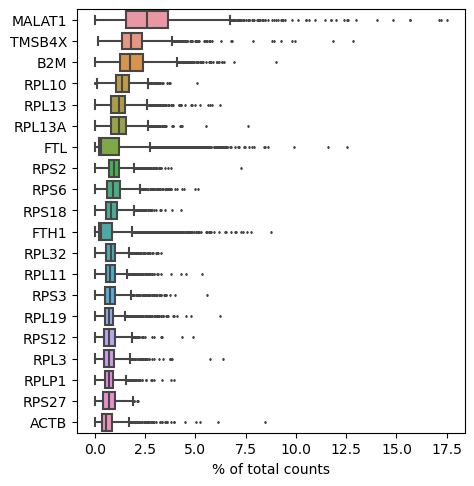

In [47]:
# Show those genes that yield the highest fraction of counts in each single cell, across all cells.
sc.pl.highest_expr_genes(adata, n_top=20, )

In [30]:
# Basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

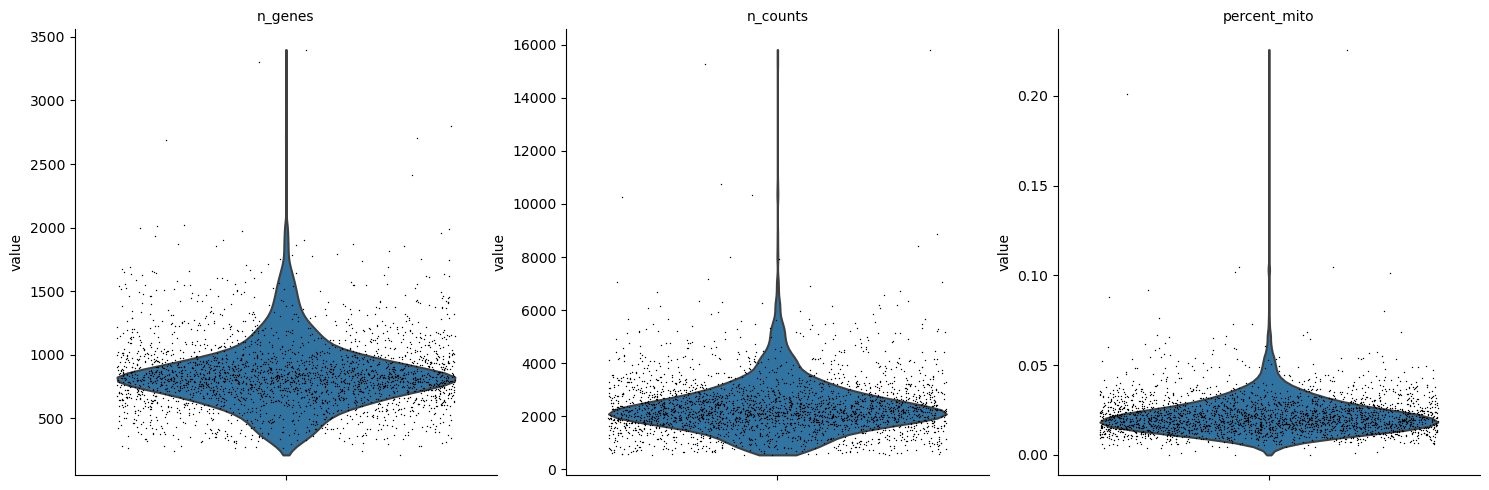

View of AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells'


In [31]:
# quality control
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
                jitter=0.4, multi_panel=True)

adata = adata[adata.obs['n_genes'] < 2500, :]
adata = adata[adata.obs['percent_mito'] < 0.05, :]
print(adata)


In [35]:
# Normalize the data
sc.pp.normalize_total(adata, target_sum=1e4)

# Logarithmize the data
sc.pp.log1p(adata)


In [36]:
# Store the raw data
adata.raw = adata

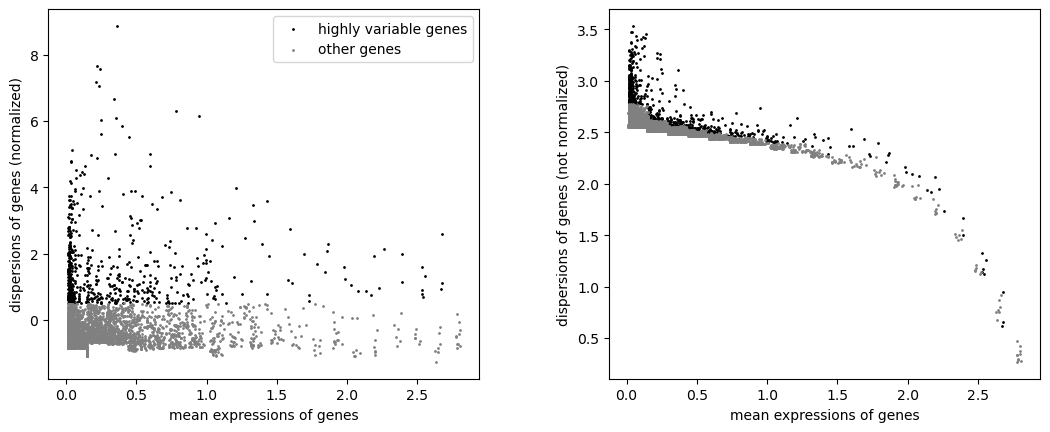

572


In [39]:
# Identify highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

# Filter the data
adata = adata[:, adata.var.highly_variable]

# Summarize the highly variable genes
print(adata.var.highly_variable.sum())


In [40]:
# Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed.
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])


In [41]:
# Scale each gene to unit variance. Clip values exceeding standard deviation 10 to remove extreme outliers.
sc.pp.scale(adata, max_value=10)

In [42]:
adata

AnnData object with n_obs × n_vars = 2638 × 572
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg'

## Dimension Reduction

### scVAE - scvi-tools

In [43]:
import scvi
print(scvi.__version__)

0.20.3


In [44]:
adata = adata.copy()
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="n_genes")

ValueError: counts is not a valid key in adata.layers.

In [12]:
# Setup the adata object for scVI
scvi.data.setup_anndata(adata, batch_key="n_genes")


AttributeError: module 'scvi' has no attribute 'setup_anndata'

In [ ]:
from scvi.model import SCVI

# Initialize the model
model = SCVI(adata)

# Train the model
model.train()


In [ ]:
# Extract the latent space representation
latent_representation = model.get_latent_representation()

# The result is a numpy array with the reduced representation
print(latent_representation)


In [ ]:
# Visualize the latent space
latent_x = latent_representation[:, 0]
latent_y = latent_representation[:, 1]

plt.figure(figsize=(8, 6))
plt.scatter(latent_x, latent_y, s=5, alpha=0.7)
plt.title('scVAE - Latent Space')
plt.xlabel('Latent Dim 1')
plt.ylabel('Latent Dim 2')
plt.show()
